Example using dask-gateway with a JupyterHub sandbox, intake-esm (on S3 NetCDF)


Author: A.Radhakrishnan, Feb 2021

using t2.xlarge

In [64]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import xarray as xr
import intake,yaml
import intake_esm
import numpy as np
%matplotlib inline

In [3]:
#%pip install ipywidgets

In [65]:
import sys
from dask_gateway import Gateway
gateway = Gateway()
clusters = gateway.list_clusters()
clusters

[]

In [66]:
if len(clusters) >0:
    cluster = gateway.connect(clusters[0].name)
    print("using existing connection")
else:
    from dask_gateway import GatewayCluster
    cluster = GatewayCluster()

In [67]:
from distributed import Client

client = Client(cluster)
client

#cluster.adapt(active=False)

<Client: 'tls://192.168.27.46:8786' processes=0 threads=0, memory=0 B>

In [69]:
options = gateway.cluster_options()  
options
#DO NOT CHANGE THIS FOR NOW

In [70]:
#Try this first if you're trying it for the first time. cluster.scale(2)
cluster.adapt(minimum=0, maximum=6)  # scale between 0 and 6 workers


In [34]:
#pip install intake_esm intake netcdf4 %pip install dask_gateway

esgf-world.json is the ESM collections spec file for the netCDF data in the S3 bucket esgf-world. 
The catalog is updated on an on-demand basis for now. 
You can refer to https://github.com/aradhakrishnanGFDL/gfdl-aws-analysis/tree/community/esm-collection-spec-examples for the most recent catalogs
More examples can be found in https://github.com/aradhakrishnanGFDL/gfdl-aws-analysis/tree/community/examples 


In [71]:
col_url = "https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.json" 
#col_url = "https://raw.githubusercontent.com/aradhakrishnanGFDL/gfdl-aws-analysis/community/esm-collection-spec-examples/esgf-world.json"

In [72]:
col = intake.open_esm_datastore(col_url)

In [73]:
col.df

project institute    model   experiment_id frequency modeling_realm  \
0        CMIP6   AS-RCEC  TaiESM1  histSST-piNTCF       NaN            NaN   
1        CMIP6   AS-RCEC  TaiESM1  histSST-piNTCF       NaN            NaN   
2        CMIP6   AS-RCEC  TaiESM1  histSST-piNTCF       NaN            NaN   
3        CMIP6   AS-RCEC  TaiESM1         histSST       NaN            NaN   
4        CMIP6   AS-RCEC  TaiESM1         histSST       NaN            NaN   
...        ...       ...      ...             ...       ...            ...   
424087   CMIP6       THU    CIESM          ssp585       mon          atmos   
424088   CMIP6       THU    CIESM          ssp585       mon          atmos   
424089   CMIP6       THU    CIESM          ssp585       mon          atmos   
424090   CMIP6       THU    CIESM          ssp585       mon          ocean   
424091   CMIP6       THU    CIESM          ssp585       mon          ocean   

       mip_table ensemble_member grid_label variable temporal subset  \
0         AERmon        r1i1p1f1         gn       ps   185001-201412   
1          CFmon        r1i1p1f1         gn       ta   185001-201412   
2           Lmon        r1i1p1f1         gn       rh   185002-201412   
3         AERmon        r1i1p1f1         gn       ps   185001-201412   
4          CFmon        r1i1p1f1         gn       ta   185001-201412   
...          ...             ...        ...      ...             ...   
424087      Amon        r1i1p1f1         gr     rlds   201501-210012   
424088      Amon        r1i1p1f1         gr     rsds   201501-210012   
424089      Amon        r1i1p1f1         gr       ta   201501-210012   
424090      Omon        r1i1p1f1         gn   thetao   201501-206412   
424091      Omon        r1i1p1f1         gn   thetao   206501-210012   

          version                                               path  
0       v20200318  s3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiES...  
1       v20200318  s3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiES...  
2       v20200318  s3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiES...  
3       v20200310  s3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiES...  
4       v20200316  s3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiES...  
...           ...                                                ...  
424087  v20200417  s3://esgf-world/CMIP6/ScenarioMIP/THU/CIESM/ss...  
424088  v20200417  s3://esgf-world/CMIP6/ScenarioMIP/THU/CIESM/ss...  
424089  v20200417  s3://esgf-world/CMIP6/ScenarioMIP/THU/CIESM/ss...  
424090  v20200220  s3://esgf-world/CMIP6/ScenarioMIP/THU/CIESM/ss...  
424091  v20200220  s3://esgf-world/CMIP6/ScenarioMIP/THU/CIESM/ss...  

[424092 rows x 13 columns]

In [74]:
#Examples to just search for what we want from the catalog
expname_filter = ['historical']
table_id_filter = 'Amon'
model_filter = 'GFDL-ESM4'
variable_id_filter = "tas"
ens_filter = "r1i1p1f1"
version_filter = "v20190726"
cat = col.search(experiment_id=expname_filter, mip_table=table_id_filter,model=model_filter,variable=variable_id_filter,version="v20190726")

In [75]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 1}},storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


In [76]:
hxr_gfdl_esm4 = dset_dict["CMIP6.NOAA-GFDL.GFDL-ESM4.historical.Amon"]

In [77]:
cat.df

project  institute      model experiment_id frequency modeling_realm  \
0   CMIP6  NOAA-GFDL  GFDL-ESM4    historical       mon          atmos   
1   CMIP6  NOAA-GFDL  GFDL-ESM4    historical       mon          atmos   

  mip_table ensemble_member grid_label variable temporal subset    version  \
0      Amon        r1i1p1f1        gr1      tas   185001-194912  v20190726   
1      Amon        r1i1p1f1        gr1      tas   195001-201412  v20190726   

                                                path  
0  s3://esgf-world/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4...  
1  s3://esgf-world/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4...

! GLOBAL MEAN 
let hgtas = tas[x=@ave,y=@ave,d=1,l=529:780@ave]


In [78]:
tas = hxr_gfdl_esm4.tas

CPU times: user 160 ms, sys: 18.3 ms, total: 178 ms
Wall time: 9.03 s


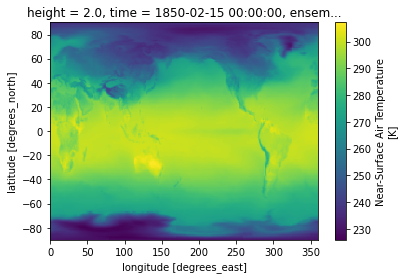

In [79]:

%time hgtas2d = tas.isel(time=1).plot()


In [82]:
cluster.close()
client.close()
#you can also set an auto close when you create a cluster , refer dask gateway docs